In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm.notebook import tqdm, trange
import torch
import autograd.numpy as np
import autograd.scipy.stats as stats
import scipy.optimize as optimize
from autograd.scipy.linalg import logm
from autograd import grad, jacobian, hessian
import numpy
import scipy
import pandas as pd
import ipywidgets as widgets

In [2]:
def decode_q_params(encoded_q):
        shape = len(encoded_q)
        mean_shape = int(shape/3)
        A_shape = (int(np.sqrt(shape - mean_shape)), int(np.sqrt(shape - mean_shape)))
        mean = encoded_q[0:mean_shape]
        A = encoded_q[mean_shape:shape].reshape(A_shape)
        return mean, A
def encode_q_params(q_params):
    mean, A = q_params
    return np.array(list(mean) + list(A.flatten()))

def decode_d(encoded_d, dim=2):
    return encoded_d.reshape(int(len(encoded_d)/dim), dim)
def encode_d(d):
    return d.flatten()

In [3]:
def optimizer(x0, gradient, callback=lambda x: x, rate=0.5, iters=1e1, label=None, leave=True):
    x = x0
    running_average = []
    for i in tqdm(range(int(iters)), desc=label, leave=leave):
        r = rate/(1+i*1e-1)
        g = gradient(x)
        x = -g * r + x
        if i % 1 == 0:
            if not callback(x):
                break
    return x

In [4]:
def log_posterior(theta_i, q_params):
    mean, A = q_params
    return scipy.stats.multivariate_normal.logpdf(theta_i, mean=mean, cov=A @ A.T)

In [98]:
def elbo(q_params, d, y_i, shape=2):
    #print('y_i 2', str(y_i))
    def stable_multivariate_gaussian_logpdf(x, mu, cov):
        n = len(x)
        x_mu = x - mu
        try:
            _, log_det = np.linalg.slogdet(cov)
            cov_inv = np.linalg.inv(cov)
            log_prob = -0.5 * (n * np.log(2 * np.pi) + log_det + np.dot(x_mu, np.dot(cov_inv, x_mu)))
        except np.linalg.LinAlgError:
            cov_modified = cov + np.eye(n) * 1e-8
            _, log_det = np.linalg.slogdet(cov_modified)
            cov_inv = np.linalg.inv(cov_modified)
            log_prob = -0.5 * (n * np.log(2 * np.pi) + log_det + np.dot(x_mu, np.dot(cov_inv, x_mu)))
        return log_prob
    def log_likelihood(y, theta, d):
        #print(y, theta, d)
        likelihood_cov = np.mean(np.square(y - theta.T @ d.T)) * np.eye(len(d))
        likelihood_mean = d @ theta
        return stable_multivariate_gaussian_logpdf(y, likelihood_mean, likelihood_cov)
    def KLD(mean_q, A_q, mean_p, A_p):
        sigma_q = (A_q @ A_q.T)
        sigma_p = (A_p @ A_p.T)
        bar_sigma_q = np.linalg.norm(sigma_q)
        bar_sigma_p = np.linalg.norm(sigma_p)
        k = len(mean_q)
        return 0.5 * (np.trace(np.linalg.inv(sigma_p) @ sigma_q) + (mean_p - mean_q).T @ np.linalg.inv(sigma_p) @ (mean_p - mean_q) - k + np.log(bar_sigma_p/bar_sigma_q))
    mean, A = q_params
    values = []
    for _ in range(10):
        sample = np.random.multivariate_normal(np.zeros(shape), np.eye(shape))
        #print(A)
        #print(sample)
        theta = mean + A @ sample
        lik = log_likelihood(y_i, theta, d)
        values.append(lik)
    return 1/(len(values))*np.sum(values) - KLD(mean, A, mean_prior, A_prior)

In [6]:
def log_posterior_grad(theta_i, y_i, d, q_params):
    def training_hessian_inner(q_params):
        return elbo(decode_q_params(q_params), d, y_i)
    def training_mixed_partials_inner(encoded_q):
        #print("Encoded d %s" % str(encode_d(d)))
        #print("inner result: %s" % str(encode_d(grad(lambda d: elbo(decode_q_params(encoded_q), d, y_i))(d))))
        return encode_d(grad(lambda d: elbo(decode_q_params(encoded_q), d, y_i))(d))
    training_hessian = hessian(training_hessian_inner)
    training_mixed_partials = jacobian(training_mixed_partials_inner)
    encoded_q = encode_q_params(q_params)
    latest_hessian = training_hessian(encoded_q)
    for i in range(20):
        if np.linalg.det(latest_hessian) != 0:
            #print("Encoded q: %s" % str(encoded_q))
            #print("Mixed Partials: %s" % str(training_mixed_partials(encoded_q)))
            #print("Log posterior grad ", str(- np.linalg.inv(latest_hessian) @ training_mixed_partials(encoded_q).T))
            return - np.linalg.inv(latest_hessian) @ training_mixed_partials(encoded_q).T
        latest_hessian = latest_hessian + 1e-8 * np.eye(latest_hessian.shape)
    raise ValueError("Was not able to invert hessian")

In [95]:
# Get returns mean, A for log q to approximate log_posterior
def optimal_q(d, y_i):
    thetas = []
    def objective_f(encoded_q):
        q_params = decode_q_params(encoded_q)
        return elbo(q_params, d, y_i)
    def callback(qi):
        mean, A = decode_q_params(qi)
        return True
        #print("\t New ELBO iteration. mean=%s, A=%s" % (str(mean), str(A)))
    results = optimizer(encode_q_params((mean_prior, A_prior)), grad(objective_f), callback=callback, rate=1, label="Optimizing for q", leave=False)
    return decode_q_params(results)

In [109]:
noise = 0.2
def MI_grad(d):
    size = d.shape[0]
    N = 20
    theta_samples = np.random.multivariate_normal(mean_prior, A_prior, size=N)
    sample_results = []
    elbos = []
    optimal_qs = []
    for i in tqdm(range(N), desc="Computing optimal q samples", leave=False):
        theta_i = theta_samples[i]
        z_i = np.random.multivariate_normal(np.zeros(size), noise * np.eye(size))
        y_i = theta_i @ d.T + z_i
        q_params = optimal_q(d, y_i)
        optimal_qs.append(q_params)
        result = log_posterior_grad(theta_i, y_i, d, q_params) * (log_posterior(theta_i, q_params) + 1)
        sample_results.append(result)
        elbos.append(elbo(q_params, d, y_i))
    optimal_params.append(optimal_qs)
    #print("ELBO: ", str(np.mean(elbos)))
    #print("MI_grad: ", str(np.mean(sample_results)))
    return np.mean(sample_results)


In [118]:
d0 = np.array([[1,1], [2,2], [3,9]])
A_prior = np.array([[3.2, 1.6], [1.1, 2.9]]) * 10
mean_prior = np.array([2, 5])
optimal_params = []
dis = []
def callback(di):
    #print("New MI iteration. di=%s" % str(di))
    dis.append(di)
    return True
optimizer(d0, MI_grad, callback=callback, label="Optimizing for d", rate=1, iters=30)

Optimizing for d:   0%|          | 0/30 [00:00<?, ?it/s]

Computing optimal q samples:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Computing optimal q samples:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Computing optimal q samples:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Computing optimal q samples:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

Optimizing for q:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

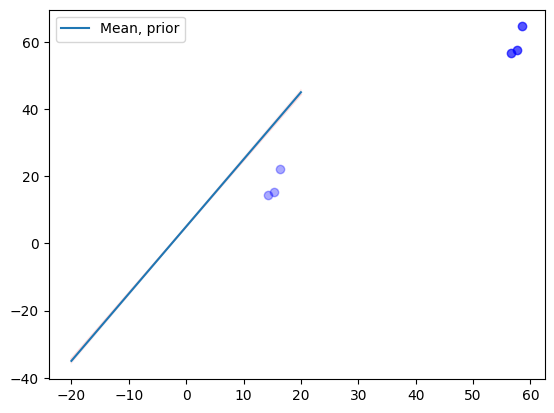

In [119]:
plots = []
for i, (di, q_params) in enumerate(zip(dis, optimal_params)):
    mean = np.mean([mean for mean, A in q_params], axis=0)
    xs = np.array([np.linspace(-20, 20, 100), np.ones(100)]).T
    ys = mean @ xs.T
    plt.scatter(di[:, 0], di[:, 1], alpha=i/len(dis), c='blue')
    p = plt.plot(xs[:,0], ys, alpha=i/(len(dis)+10), c='red')
    plots.append(p)
plt.plot(xs[:, 0], mean_prior @ xs.T, label="Mean, prior")
plt.legend()
plots[0]
#plots = [plt.plot(x, y) for y in range(10)]

# Example in practice: Red Wine Alcohol Level
To test this in practice, we are first train a linear model to predict the alcohol of a given portugese red wine.
Then we are going to predict 10 hypothetical red wines that we wish to produce that can increase our confidence in this model.

Dataset is from Kaggle: https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009?resource=download

In [40]:
from sklearn import linear_model
from sklearn.decomposition import PCA

In [18]:
data_set = pd.read_csv("winequality-red.csv")
data_set

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [56]:
X = data_set[["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates"]]
y = data_set["quality"]

In [68]:
clf = linear_model.BayesianRidge()
clf.fit(X, y)
clf.get_params()

{'alpha_1': 1e-06,
 'alpha_2': 1e-06,
 'alpha_init': None,
 'compute_score': False,
 'copy_X': True,
 'fit_intercept': True,
 'lambda_1': 1e-06,
 'lambda_2': 1e-06,
 'lambda_init': None,
 'n_iter': 300,
 'tol': 0.001,
 'verbose': False}

In [47]:
pca = PCA(n_components=10)
pca.fit(X)

PCA(n_components=10)

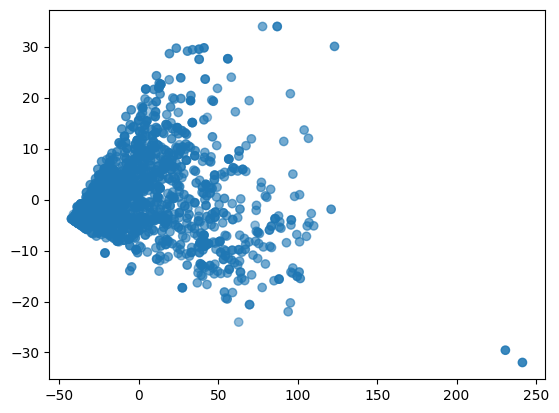

In [66]:
plt.scatter(pca.transform(X)[:, 0], pca.transform(X)[:, 1], alpha=y/np.max(y))